In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import time
import zipfile
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
from shapely.geometry import mapping 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.patches as mpatches


plot_kwargs = {'bbox_inches': "tight", 'dpi': 300}

In [2]:
basedir = os.path.join(os.getcwd(), "..")
datadir = os.path.join(basedir, "Rapid Input")
uk_crs = 'EPSG:27700'
BUFFERS = np.array([5, 10, 25, 50, 100, 150, 200, 500]) * 1000 # km radius of buffers
BACKCASTS = [3, 6, 12, 24, 36]
# YEARS = [str(year) for year in np.arange(1892, 2015)]

## Script 1: set up buffer circles in centroids of WRZs

Number of water resource zones: 99
Number of water resource zones with associated WREW codes: 30
Number of water resource zones in buffer dataframe: 30


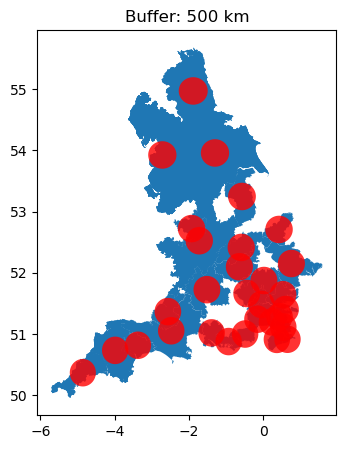

In [3]:
# load and merge WRZ dataframes
wrz = gpd.read_file(os.path.join(datadir, 'WRZ', 'WRZ.shp'), crs=uk_crs).to_crs('EPSG:4326')
print(f"Number of water resource zones: {wrz['RZ_ID'].nunique()}")
wrz_code = pd.read_excel(os.path.join(datadir, 'WRZ', 'wrz_code.xlsx'))
wrz_code['RZ ID'] = pd.to_numeric(wrz_code['RZ ID'])
wrz = wrz.merge(wrz_code, left_on='RZ_ID', right_on='RZ ID')
print(f"Number of water resource zones with associated WREW codes: {wrz['RZ_ID'].nunique()}")

# extract centroids of wrzs
wrz_centroid = wrz.copy().to_crs(uk_crs)
wrz_centroid['centroid_x'] = wrz_centroid.geometry.centroid.x
wrz_centroid['centroid_y'] = wrz_centroid.geometry.centroid.y
wrz_centroid = gpd.GeoDataFrame(wrz_centroid, geometry=gpd.points_from_xy(wrz_centroid.centroid_x, wrz_centroid.centroid_y), crs={'init':uk_crs})

# create buffer dataframes
wrz_buffers = []
for buffer in BUFFERS:
    wrz_buffer = wrz_centroid.copy()
    wrz_buffer['geometry'] = wrz_buffer['geometry'].buffer(buffer).to_crs(4326)
    wrz_buffer['buffer'] = [buffer / 1000] * len(wrz_buffer)
    wrz_buffer = wrz_buffer[['RZ_ID', 'geometry', 'buffer']].drop_duplicates()
    wrz_buffers.append(wrz_buffer)

wrz_buffer = wrz_buffers[2]
# plot
fig, ax = plt.subplots(figsize = (10, 5))
wrz.plot(ax=ax)
wrz_buffer.plot(ax=ax, color='red', alpha=0.8)
ax.set_title(f"Buffer: {buffer / 1000:.0f} km")

fig.savefig(os.path.join(datadir, "figures", "wrz_examples.png"), **plot_kwargs)

wrz_buffer = pd.concat(wrz_buffers).sort_values(by=['RZ_ID', 'buffer'], ascending=True)[['RZ_ID', 'buffer', 'geometry']]
print(f"Number of water resource zones in buffer dataframe: {wrz_buffer['RZ_ID'].nunique()}")

## Load UKCP19 river basin data
* Intersect the basins wth the wrz
* For each wrz, get unary union of all basins it intersects
* Each wrz has geometry corresponding to union of all basins it intersects

In [4]:
basins = gpd.read_file(os.path.join(datadir, 'river_basins', 'ukcp18-uk-land-river-hires.gpkg')).to_crs(4326)
assert basins.crs == wrz.crs
assert wrz.crs == wrz_buffer.crs

wrz_basins = wrz[['RZ_ID', 'geometry']].sjoin(basins[['id', 'geometry']], how='left', predicate='intersects') # 36 -> 15
basin_geoms = {idx: geom for idx, geom in zip(basins.id, basins.geometry)}

wrz_basins['geometry'] = wrz_basins['id'].apply(lambda x: basin_geoms[x])
wrz_basins = wrz_basins.set_geometry('geometry')

basins_dissolved = wrz_basins.dissolve(by='RZ_ID').reset_index()
rz_basin_geoms = {rz_id: basin_geom for rz_id, basin_geom in zip(basins_dissolved['RZ_ID'], basins_dissolved['geometry'])}

assert basins_dissolved['RZ_ID'].nunique() == wrz_buffer['RZ_ID'].nunique(), 'Number of RZ IDs changed.'

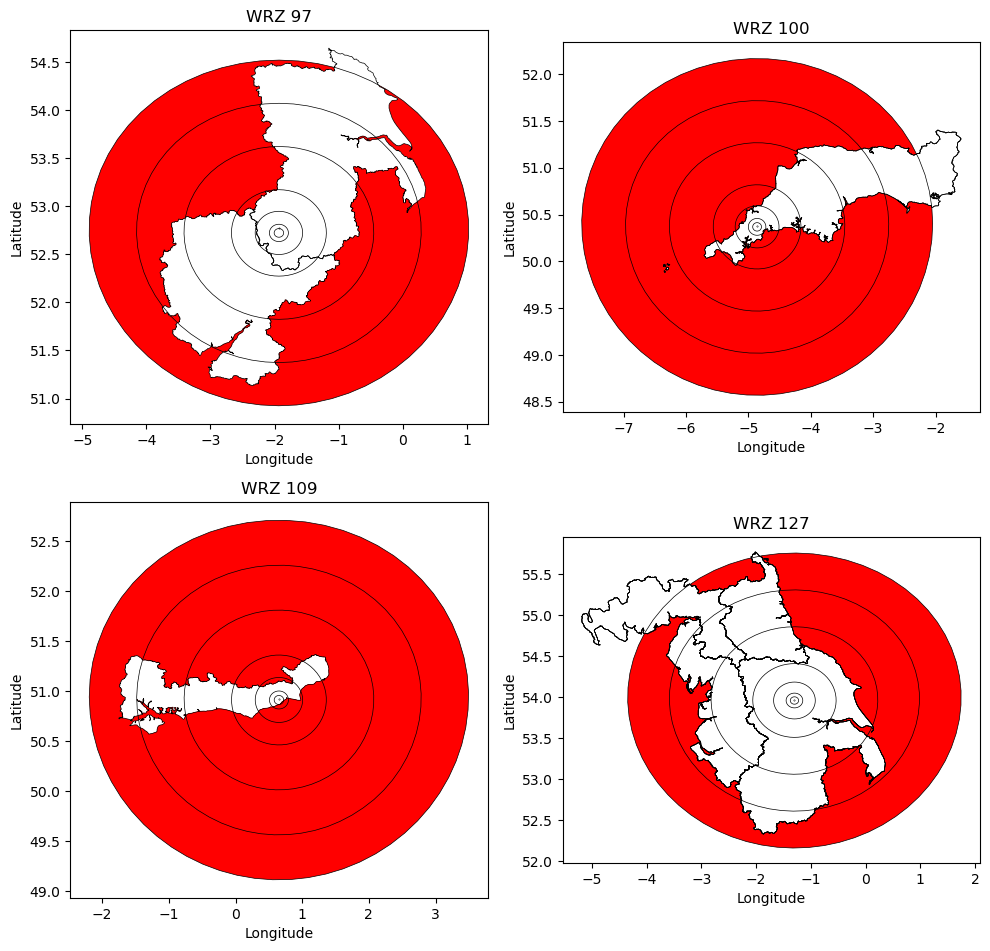

In [5]:
RZ_IDs = [97, 100, 109, 127]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), layout='tight')

for rz_id, ax in zip(RZ_IDs, axs.ravel()):
    basins_to_plot = wrz_basins.query(f'RZ_ID == {rz_id}')
    basins_to_plot.boundary.plot(color='k', ax=ax, linewidth=.5, aspect=1)
    wrz_buffer.query(f'RZ_ID == {rz_id} and buffer == {buffer / 1000}').centroid.plot(color='k', ax=ax, markersize=.1)
    for buffer in BUFFERS[:-1]:
        buffer_to_plot = wrz_buffer.query(f'RZ_ID == {rz_id} and buffer == {buffer / 1000}')
        buffer_to_plot.boundary.plot(color='k', ax=ax, linewidth=.5, aspect=1)
        external = buffer_to_plot.overlay(basins_to_plot, how='difference')
        external.plot(ax=ax, facecolor='red', aspect=1.5, label='excluded', legend=True)
        
#     # plot biggest buffer differently (leaving out because makes figure less clear)
#     buffer = BUFFERS[-1]
#     buffer_to_plot = wrz_buffer.query(f'RZ_ID == {rz_id} and buffer == {buffer / 1000}')
#     buffer_to_plot.boundary.plot(color='k', ax=ax, linewidth=.5, aspect=1)
#     external = buffer_to_plot.overlay(basins_to_plot, how='difference')
#     external.plot(ax=ax, facecolor='none', hatch='//', aspect=1.5, label='excluded', legend=True, zorder=0) # 
    
    ax.set_title(f'WRZ {rz_id}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
fig.savefig(os.path.join(datadir, 'figures', 'buffers_and_basins.png'), dpi=300, bbox_inches='tight')

## Load and format monthly LoS data

In [6]:
wrz_dict = {wrz_code: f'{rz_id:.0f}' for wrz_code, rz_id in zip(wrz_code['WREW Code'], wrz_code['RZ ID'])}

# load LoS data
monthly_los = pd.read_csv(os.path.join(datadir, 'los', 'weighted_monthly_LoS_Hist.csv'))
monthly_los.columns = monthly_los.iloc[0]
cols = ['Ensemble','Year', 'Month'] + list(monthly_los.columns)[3: len(list(monthly_los.columns))]
monthly_los.columns = cols
monthly_los = monthly_los.iloc[3:].reset_index(drop=True)
monthly_los['Year'] = pd.to_numeric(monthly_los['Year'], downcast='integer')
monthly_los['Month'] = pd.to_numeric(monthly_los['Month'], downcast='integer')

cols = [*monthly_los.columns]
monthly_los = monthly_los.groupby(cols).sum().reset_index()

# melt dataframe for merging with pet data
rz_id_cols = monthly_los.columns[3:]
monthly_los_melted = monthly_los.melt(id_vars=['Year', 'Month'], value_vars=rz_id_cols, var_name='RZ_ID', value_name='LoS', ignore_index=True)
monthly_los_melted = monthly_los_melted[['RZ_ID', 'Year', 'Month', 'LoS']]

monthly_los_melted['RZ_ID'] = monthly_los_melted['RZ_ID'].map(wrz_dict)
monthly_los_melted['LoS'] = monthly_los_melted['LoS'].astype(float)
monthly_los_melted = monthly_los_melted[monthly_los_melted['RZ_ID'] != 'nan']
monthly_los_melted = monthly_los_melted.drop_duplicates()

YEARS = [str(year) for year in monthly_los_melted['Year'].unique()]

print(f"Number of LoS days: {monthly_los_melted['LoS'].sum():.0f}")
monthly_los_melted[monthly_los_melted['LoS'] > 0]

Number of LoS days: 12103


,RZ_ID,Year,Month,LoS
145,1,1974,3,27.0
146,1,1974,4,30.0
147,1,1974,5,2.0
176,1,1976,10,29.0
177,1,1976,11,30.0
...,...,...,...,...
31469,127,1996,7,998.0
31470,127,1996,8,2480.0
31471,127,1996,9,2400.0
31472,127,1996,10,2480.0


## Load and format W@H CEH Gridded Estimates of Effective Precipitation

In [7]:
def condition(filename, year):
    if (filename.split('.')[-1] == 'nc') and (year in filename):
        return True
    else:
        return False

def process_wah_file(filename, wah_archive):
    file = wah_archive.open(filename)
    df = xr.open_dataset(file)
    df = df.to_dataframe().reset_index()
    df['lat'] = df['y'].round(2)
    df['lon'] = df['x'].round(2)
    df['time'] = pd.to_datetime(df['time'])
    df['Year'] = df['time'].dt.year
    df['Month'] = df['time'].dt.month
    df = df.rename(columns={'rainfall_amount': 'rainfall'})
    df_grouped = df.groupby(['lon','lat','Year','Month'])['rainfall'].sum().to_frame().reset_index()
    return df_grouped

In [8]:
# process files from the zipped W@H directory
wahpath = os.path.join(datadir, 'w@h', 'hist')
with zipfile.ZipFile(f"{wahpath}.zip", 'r') as archive:
    for year in YEARS:
        savepath = os.path.join(datadir, 'w@h', 'hist', 'yearly', f'wah_{year}.parquet')
        if not os.path.exists(savepath):
            try:
                print(f"Processing year {year}.")
                df_years = []
                files_year = [file for file in archive.namelist() if condition(file, year)]
                if len(files_year) > 0:
                    for file in files_year:
                        df_grouped = process_wah_file(file, archive)
                        df_years.append(df_grouped)
                    df_year = pd.concat(df_years)

                    # convert to EPSG:4326
                    gdf_year = gpd.GeoDataFrame(df_year, geometry=gpd.points_from_xy(df_year.lon, df_year.lat), crs={'init':uk_crs}).to_crs(4326)
                    gdf_year['lon'] = gdf_year['geometry'].x
                    gdf_year['lat'] = gdf_year['geometry'].y

                    gdf_year.to_parquet(savepath)
                    print(f"Saved as {savepath}")
                else:
                    print(f"No files found for {year}.\n")
            except Exception as e:
                print(e)
                ! say error

Processing year 1988.
No files found for 1988.



In [9]:
# for each WRZ, load all the W@H data for every year, mask to union of basin bounds and save to new df
# Time taken: 31.070839 minutes
start = time.time()
wrz = wrz[['RZ_ID', 'geometry']].drop_duplicates()
wrz['bounds'] = wrz.bounds.apply(lambda row: (row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)

for wrz_row in wrz.itertuples():
    savepath = os.path.join(datadir, "w@h", "hist", "by_basin", f"wah_{wrz_row.RZ_ID}.parquet")
    if not os.path.exists(savepath):
        print(f"Working on {wrz_row.RZ_ID}...")
        bounds = rz_basin_geoms[wrz_row.RZ_ID].bounds

        wah_dfs = []
        for year in YEARS:
            if os.path.exists(os.path.join(datadir, 'w@h', 'hist', 'yearly', f'wah_{year}.parquet')):

                ddf = dd.read_parquet(os.path.join(datadir, 'w@h', 'hist', 'yearly', f'wah_{year}.parquet'),
                                      filters=[[('lon', '>=', bounds[0]),
                                        ('lat', '>=', bounds[1]),
                                        ('lon', '<=', bounds[2]),
                                        ('lat', '<=', bounds[3])]],
                                      columns=['lon', 'lat', 'Year', 'Month', 'rainfall'])


                df = ddf.compute()
                gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326).clip(rz_basin_geoms[wrz_row.RZ_ID])
                wah_dfs.append(gdf)


        wah_df = pd.concat(wah_dfs)

        # add all the extra metrics
        q50 = wah_df.groupby("Month")['rainfall'].quantile(.5).to_frame()
        q75 = wah_df.groupby("Month")['rainfall'].quantile(.75).to_frame()
        q90 = wah_df.groupby("Month")['rainfall'].quantile(.9).to_frame()
        wah_df = pd.merge(wah_df, q50, on='Month', how='left', suffixes=('', '_q50'))
        wah_df = pd.merge(wah_df, q75, on='Month', how='left', suffixes=('', '_q75'))
        wah_df = pd.merge(wah_df, q90, on='Month', how='left', suffixes=('', '_q90'))
        wah_df[['Year', 'Month', 'rainfall', 'rainfall_q50','rainfall_q75', 'rainfall_q90', 'geometry']].to_parquet(savepath) # check subset ok

print(f"Time taken: {(time.time() - start) / 60 :2f} minutes")

Time taken: 0.001046 minutes


In [10]:
if False:
    # plot distribution of median rainfall
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    
    wah_df = pd.read_parquet(os.path.join(datadir, "w@h", "hist", "by_basin", f"wah_{wrz_row.RZ_ID}.parquet"))

    ax = axs[0]
    jan = wah_df[wah_df.Month == 1]
    jan['rainfall'].hist(bins=100, ax=ax, density=True)
    ax.axvline(jan['rainfall'].quantile(.5), color='red')
    ax.set_title('January')


    ax = axs[1]
    june = wah_df[wah_df.Month == 6]
    june['rainfall'].hist(bins=100, ax=ax, density=True)
    ax.axvline(june['rainfall'].quantile(.5), color='red')
    ax.set_title('June')

    ax = axs[2]
    october = wah_df[wah_df.Month == 10]
    october['rainfall'].hist(bins=100, ax=ax, density=True)
    ax.axvline(october['rainfall'].quantile(.5), color='red')
    ax.set_title('October')

    del jan, june, october

    fig.savefig(os.path.join(datadir, "figures", "rainfall_histograms.png"), **plot_kwargs)

## Intersect rainfall data with WRZ buffers

In [11]:
def get_full_ts(wah, monthly_los):
    wah["RZ_ID"] = wah['RZ_ID'].astype(int)
    monthly_los["RZ_ID"] = monthly_los['RZ_ID'].astype(int)
    full_ts = wah.merge(monthly_los, on=['RZ_ID', 'Year', 'Month'], how='inner')
    full_ts = full_ts.sort_values(by=['RZ_ID', 'Year', 'Month', 'LoS', 'buffer'])
    full_ts = full_ts[['RZ_ID', 'Year', 'Month', 'LoS', 'buffer', 'rainfall_total', 'rainfall_mean', 'q50_anomaly_total', 'q75_anomaly_total', 'q90_anomaly_total', 'q50_deficit_total']]
    import pdb; pdb.set_trace()
    return full_ts

In [12]:
# >>> ts = pd.read_parquet("wah_1.parquet", filters=[("buffer", "=", 5.)])
import time

agg_kwargs= {
    "rainfall_total": ("rainfall", sum),
    "rainfall_mean": ("rainfall", np.mean),
    "rainfall_q50_total": ("rainfall_q50", sum),
    "rainfall_q75_total": ("rainfall_q75", sum),
    "rainfall_q90_total": ("rainfall_q90", sum),
}

times = []
for wrz_row in wrz.itertuples():
    pathname_buffer = os.path.join(datadir, 'processed_data', 'hist', 'buffers', f'wah_{wrz_row.RZ_ID}.parquet')
    pathname_ts = os.path.join(datadir, 'processed_data', 'hist', 'full_timeseries', f'wah_{wrz_row.RZ_ID}.parquet')
    if not os.path.exists(pathname_ts):
        start = time.time()
        print(f"Processing WRZ {wrz_row.RZ_ID}")
        # if the files aren't there make them again
        buffers_wrz = wrz_buffer[wrz_buffer['RZ_ID']==wrz_row.RZ_ID].sort_values(by="buffer", ascending=True)

        # only do overlay for one month to save time
        wah_coords = gpd.read_parquet(os.path.join(datadir, "w@h", "hist", "by_basin", f"wah_{wrz_row.RZ_ID}.parquet"), filters=[("Year", "=", 1962), ("Month", "=", 1)])
        assert wah_coords.crs == buffers_wrz.crs, "Dataframes have different coordinate reference systems"
        wah_map = gpd.overlay(wah_coords, buffers_wrz, how='intersection')
        wah_map = wah_map[['geometry', 'RZ_ID', 'buffer']].set_index('geometry')

        wah_gdf = gpd.read_parquet(os.path.join(datadir, "w@h", "hist", "by_basin", f"wah_{wrz_row.RZ_ID}.parquet"))
        print(f"Total number of rows: {len(wah_gdf):,}")

        print("Intersecting...")
        wah_buffer = wah_gdf.join(wah_map, on='geometry', how='outer', lsuffix='_', rsuffix='_r')
        wah_buffer = wah_buffer[['RZ_ID', 'Year', 'Month', 'buffer', 'rainfall', 'rainfall_q50', 'rainfall_q75', 'rainfall_q90']].groupby(['RZ_ID', 'buffer', 'Year', 'Month']).agg(**agg_kwargs).reset_index()

        print('Calculating anomalies...')
        # calculate metrics
        wah_buffer['q50_anomaly_total'] = wah_buffer['rainfall_total'] - wah_buffer['rainfall_q50_total']
        wah_buffer['q75_anomaly_total'] = wah_buffer['rainfall_total'] - wah_buffer['rainfall_q75_total']
        wah_buffer['q90_anomaly_total'] = wah_buffer['rainfall_total'] - wah_buffer['rainfall_q90_total']
        wah_buffer['q50_deficit_total'] = (wah_buffer['rainfall_q50_total'] - wah_buffer['rainfall_total']).apply(lambda x: np.max([x, 0.]))

        # save
        print("Saving...")
        wah_buffer = wah_buffer[['RZ_ID', 'Year', 'Month', 'buffer', 'rainfall_total', 'rainfall_mean', 'q50_anomaly_total', 'q75_anomaly_total', 'q90_anomaly_total', 'q50_deficit_total']]
        wah_buffer.to_parquet(pathname_buffer)

        import pdb; pdb.set_trace()
        # also save the full time series to use later
        full_ts = get_full_ts(wah_buffer, monthly_los_melted)
        full_ts.to_parquet(pathname_ts)

        duration = (time.time() - start) / 60
        print(f"Time taken: {duration:.2f} mins.")
        times.append(duration)

print(f"{np.mean(times):.2f} minutes per wrz")

nan minutes per wrz


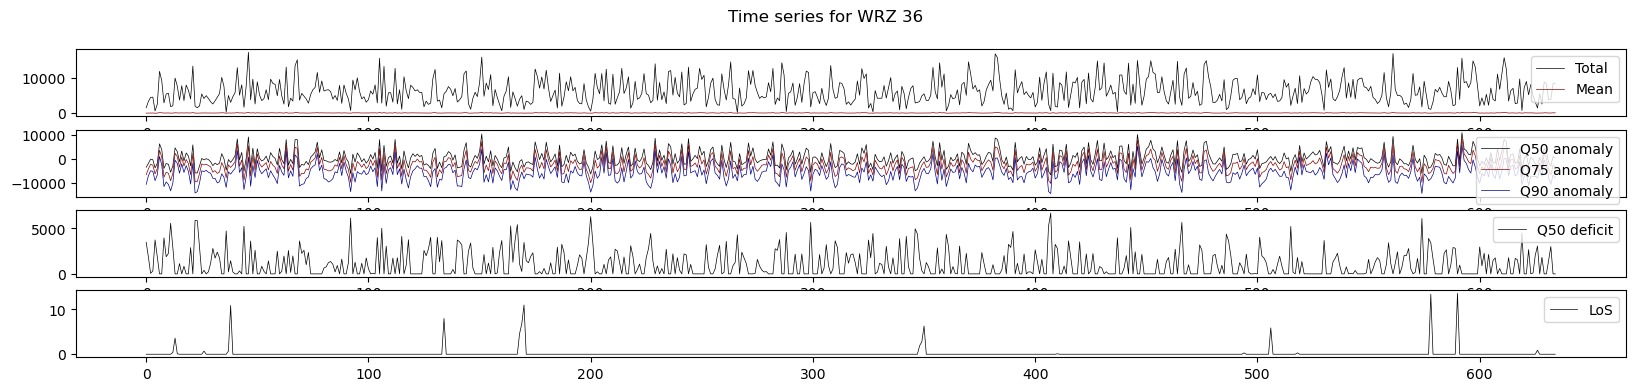

In [13]:
RZ_ID = 36
pathname_ts = os.path.join(datadir, 'processed_data', 'hist', 'full_timeseries', f'wah_{RZ_ID}.parquet')
    
ts = pd.read_parquet(pathname_ts, filters=[("buffer", "=", 5.)])


fig, axs = plt.subplots(4, 1, figsize=(20, 4))

axs[0].plot(range(len(ts)), ts['rainfall_total'], label="Total", color='k', linewidth=.5)
axs[0].plot(range(len(ts)), ts['rainfall_mean'], label='Mean', color='darkred', linewidth=.5)

axs[1].plot(range(len(ts)), ts['q50_anomaly_total'], label='Q50 anomaly', color='k', linewidth=.5)
axs[1].plot(range(len(ts)), ts['q75_anomaly_total'], label='Q75 anomaly', color='darkred', linewidth=.5)
axs[1].plot(range(len(ts)), ts['q90_anomaly_total'], label='Q90 anomaly', color='darkblue', linewidth=.5)

axs[2].plot(range(len(ts)), ts['q50_deficit_total'], label='Q50 deficit', color='k', linewidth=.5)

axs[3].plot(range(len(ts)), ts['LoS'], label='LoS', color='k', linewidth=.5)
for ax in axs:
    ax.legend(loc='upper right')
fig.suptitle(f"Time series for WRZ {ts['RZ_ID'][0]}")

fig.savefig(os.path.join(datadir, 'figures', f"time_series_{ts['RZ_ID'][0]}.png"), dpi=300, bbox_inches='tight')

## Get event-wise dataframe

In [14]:
def get_events(df):
    """Process melted LoS dataframe to extract events"""
    df = df.drop_duplicates()
    
    events_ind = df[df['LoS'] > 0].index
    df = df.loc[events_ind]
    df = df.sort_values(by=['RZ_ID', 'Year', 'Month'], ascending=True)
    
    df['Day'] = [1] * len(df)
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['diff'] = df['date'].dt.to_period('M').astype(int).diff().replace(np.nan, 0).astype(int)
    df['event'] = (df['diff'] != 1).cumsum()

    agg_kwargs = {'start': ('date', min),
                  'end': ('date', max),
                  'severity': ('LoS', sum)}

    df = df[['RZ_ID', 'event', 'date', 'LoS']].groupby(['RZ_ID', 'event']).agg(**agg_kwargs).reset_index()
    df['duration'] = (df['end'] - df['start']) + pd.Timedelta(1, 'D') # so no 0-day events
    return df


def get_predictors_in_window(df, start, end, backcast):
    # gather all entries within time window
    backcast = start - relativedelta(months=backcast)
    end = end + relativedelta(months=1)
    date_list = pd.date_range(backcast, end, freq='m')
    year_list = [date.year for date in date_list]
    month_list = [date.month for date in date_list]
    date_df = pd.DataFrame({'Year': year_list, 'Month': month_list})
    df = df.merge(date_df, on=['Year', 'Month'], how='inner')
    return df


event_df = get_events(monthly_los_melted)
all_events = []
for row in event_df.itertuples():
    rz_id = row.RZ_ID
    wah_buffer = pd.read_parquet(os.path.join(datadir, 'processed_data', 'hist', 'full_timeseries', f'wah_{row.RZ_ID}.parquet'))

    wah_events = []
    for bk in BACKCASTS:
        wah_sub = get_predictors_in_window(wah_buffer, row.start, row.end, bk)
        n = len(wah_sub)
        wah_sub['backcast'] = [int(bk)] * n
        wah_sub['start'] = [row.start] * n
        wah_sub['end'] = [row.end] * n
        wah_sub['event'] = [row.event] * n
        wah_sub['severity'] = [row.severity] * n
        wah_sub['duration'] = [row.duration] * n
        wah_events.append(wah_sub)

    wah_event = pd.concat(wah_events)[['RZ_ID', 'event', 'start', 'end', 'severity', 'duration', 'backcast', 'buffer', 'rainfall_total', 'rainfall_mean', 'q50_anomaly_total', 'q75_anomaly_total', 'q90_anomaly_total', 'q50_deficit_total']]
    wah_event = wah_event.groupby(['RZ_ID', 'event', 'start', 'end', 'severity', 'duration', 'backcast', 'buffer']).sum().reset_index()
    all_events.append(wah_event)
            
all_events = pd.concat(all_events)
all_events.to_csv(os.path.join(datadir, 'processed_data', "hist", "events", "all_events.csv"))

In [15]:
all_events

,RZ_ID,event,start,end,severity,duration,backcast,buffer,rainfall_total,rainfall_mean,q50_anomaly_total,q75_anomaly_total,q90_anomaly_total,q50_deficit_total
0,1,1,1974-03-01,1974-05-01,59.0,62 days,3,5.0,23289.3,294.801266,-1880.1,-12252.8,-23984.3,6295.7
1,1,1,1974-03-01,1974-05-01,59.0,62 days,3,10.0,94519.5,300.061905,-5839.5,-47199.0,-93976.5,24386.3
2,1,1,1974-03-01,1974-05-01,59.0,62 days,3,25.0,562940.2,292.436468,-50364.8,-303117.3,-588979.8,158433.0
3,1,1,1974-03-01,1974-05-01,59.0,62 days,3,50.0,1846717.3,279.593838,-257635.7,-1124872.2,-2105714.7,587654.9
4,1,1,1974-03-01,1974-05-01,59.0,62 days,3,100.0,4503688.4,302.119031,-245681.8,-2202970.9,-4416660.4,1347159.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,97,63,2011-11-01,2011-12-01,1.1,31 days,36,50.0,14795878.9,1956.609217,-2659485.7,-11353517.1,-22539983.7,4150046.7
36,97,63,2011-11-01,2011-12-01,1.1,31 days,36,100.0,44188125.3,2026.141744,-6153589.4,-31227396.7,-63489450.4,10778767.9
37,97,63,2011-11-01,2011-12-01,1.1,31 days,36,150.0,83768901.1,2297.115230,-407875.0,-42333984.9,-96279618.0,13070944.0
38,97,63,2011-11-01,2011-12-01,1.1,31 days,36,200.0,109788231.5,2357.387089,2286083.9,-51257744.5,-120151704.1,15164685.0


In [16]:
help(pd.Timedelta)

Help on class Timedelta in module pandas._libs.tslibs.timedeltas:

class Timedelta(_Timedelta)
 |  Timedelta(value=<object object at 0x104571c10>, unit=None, **kwargs)
 |  
 |  Represents a duration, the difference between two dates or times.
 |  
 |  Timedelta is the pandas equivalent of python's ``datetime.timedelta``
 |  and is interchangeable with it in most cases.
 |  
 |  Parameters
 |  ----------
 |  value : Timedelta, timedelta, np.timedelta64, str, or int
 |  unit : str, default 'ns'
 |      Denote the unit of the input, if input is an integer.
 |  
 |      Possible values:
 |  
 |      * 'W', 'D', 'T', 'S', 'L', 'U', or 'N'
 |      * 'days' or 'day'
 |      * 'hours', 'hour', 'hr', or 'h'
 |      * 'minutes', 'minute', 'min', or 'm'
 |      * 'seconds', 'second', or 'sec'
 |      * 'milliseconds', 'millisecond', 'millis', or 'milli'
 |      * 'microseconds', 'microsecond', 'micros', or 'micro'
 |      * 'nanoseconds', 'nanosecond', 'nanos', 'nano', or 'ns'.
 |  
 |  **kwargs
